<a href="https://colab.research.google.com/github/waleedShahid002/Image-classification-using-keras/blob/main/image_classification_accuracy-improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Intro

In [1]:
import os
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0

Load data

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  97.1M      0  0:00:08  0:00:08 --:--:-- 82.9M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip  'readme[1].txt'
 drive			   PetImages		        sample_data


Filter out corrupted images

In [4]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


Generate a dataset

In [5]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


Visualize the data

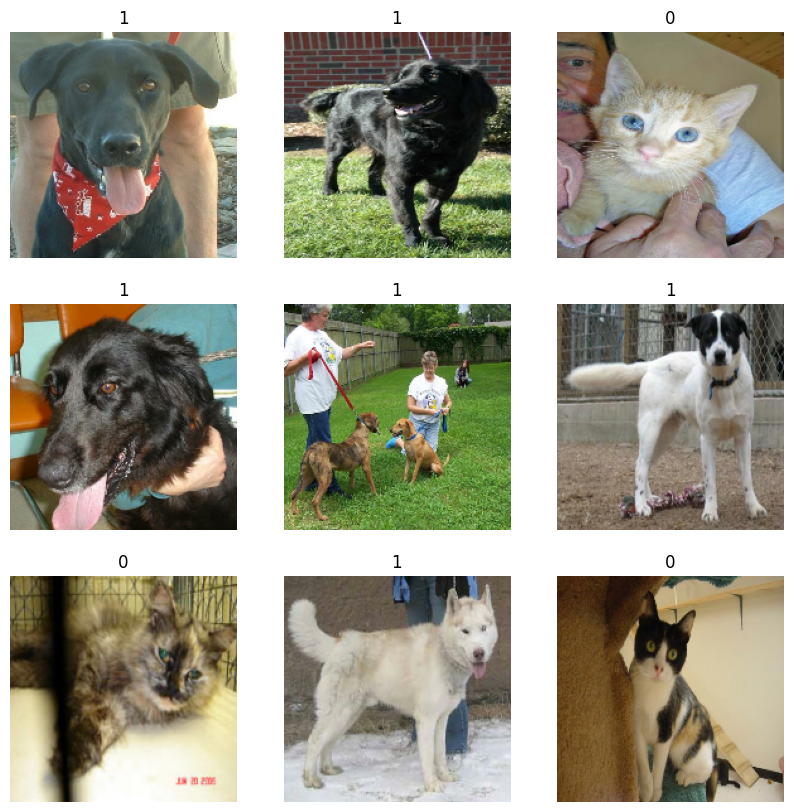

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Using data augmentation

In [7]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
     layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.RandomGrayscale(factor=0.1, data_format=None, seed=None),
    layers.RandomColorDegeneration(factor=0.1, value_range=(0, 255), data_format=None, seed=None),
    layers.RandomBrightness(factor= 0.1, value_range=(0, 255), seed=None)
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

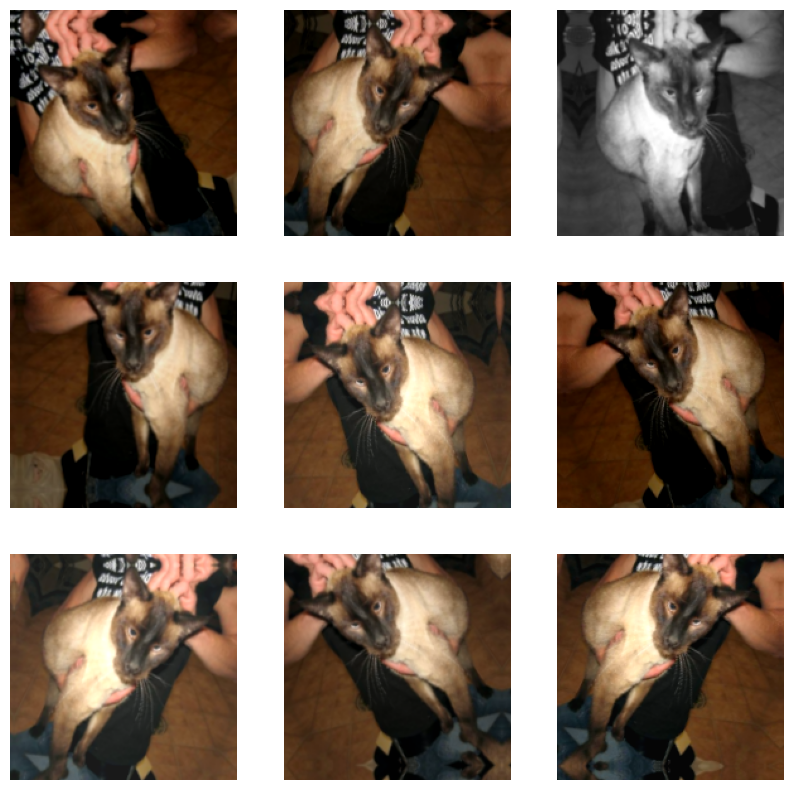

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

configure the dataset

In [9]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

Build model

In [11]:
# Load EfficientNetB0 as the base model
base_model = EfficientNetB0(
    weights='imagenet',  # Use pre-trained weights from ImageNet
    include_top=False,   # Exclude the top classification layer
    input_shape=image_size + (3,)  # Input shape for the model
)

# Freeze the base model to prevent training its layers initially
base_model.trainable = False

# Create the new model on top of the pre-trained base
inputs = keras.Input(shape=image_size + (3,))
x = base_model(inputs, training=False)  # Pass inputs through the base model
x = layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = layers.Dropout(0.2)(x)             # Add dropout for regularization
outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification output

# Build the final model
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
epochs = 25
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.8477 - loss: 0.3483 - val_accuracy: 0.9808 - val_loss: 0.0743
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9627 - loss: 0.1070 - val_accuracy: 0.9855 - val_loss: 0.0516
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9670 - loss: 0.0889 - val_accuracy: 0.9861 - val_loss: 0.0441
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9688 - loss: 0.0809 - val_accuracy: 0.9872 - val_loss: 0.0407
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9728 - loss: 0.0726 - val_accuracy: 0.9872 - val_loss: 0.0381
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9710 - loss: 0.0748 - val_accuracy: 0.9878 - val_loss: 0.0363
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9714 - loss: 0.0733 - val_accuracy: 0.9883 - val_loss: 0.0351
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9754 - loss: 0.0669 - val_accu

Confusion matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━

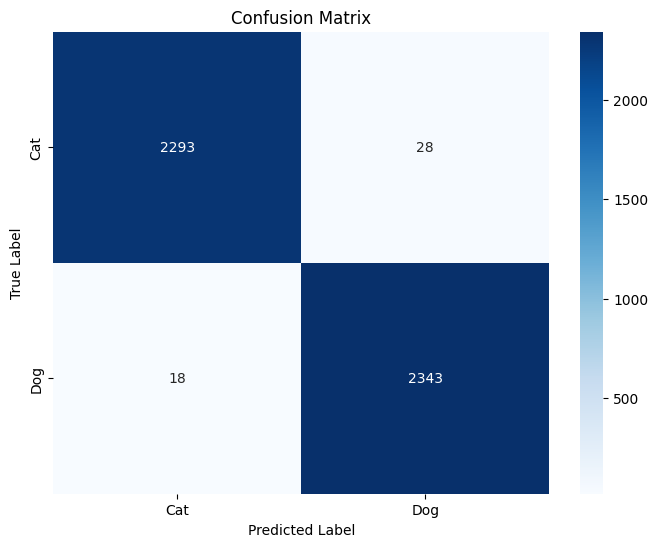


Summary Metrics:
Accuracy: 0.9902
Precision: 0.9882
F1 Score: 0.9903


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
import seaborn as sns

# Generate predictions on the validation set
val_labels = []
val_predictions = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds = np.round(preds).astype(int)  # Convert probabilities to binary predictions
    val_predictions.extend(preds)
    val_labels.extend(labels)

# Convert to numpy arrays
val_labels = np.array(val_labels).flatten()
val_predictions = np.array(val_predictions).flatten()

# Create confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate summary metrics
accuracy = accuracy_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions)  # For binary classification
f1 = f1_score(val_labels, val_predictions)  # For binary classification

# Display the summary
print("\nSummary Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
